In [1]:
import torch
import torch.nn as nn

import os
import json
from tqdm import tqdm

import src.models as mdls
import src.utils as utils

# Face recognition imports
from src.models import Triplet
from src.models import ConvEmbedding

from src.utils import TripletLoss
from src.dataloaders import recognition_dataloader

#downloading datasets
config = utils.get_options()


if config['use_colab']:
    utils.colab()
else:
    utils.check_if_datasets_are_downloaded()


import src.dataloaders as dataloaders

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

In [2]:
img_size = config['img_size']
# Define a directory to save the checkpoints
checkpoint_dir = "checkpoints/"

# Ensure the directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

#define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [3]:
img_size = config['img_size']
# Define a directory to save the checkpoints
checkpoint_dir = "checkpoints/"

# Ensure the directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

#define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
#Face detection setup
detection_model = mdls.InspectorGadjet()
dataloader_for_detection = dataloaders.detection_dataloader

# loss_fn = nn.MSELoss()
loss_fn = mdls.combined_loss
optimizer = torch.optim.Adam(detection_model.parameters(), lr=1e-3)
detection_model.to(device)
# loss_fn.to(device)

InspectorGadjet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentu

In [5]:
batch = next(iter(dataloader_for_detection))

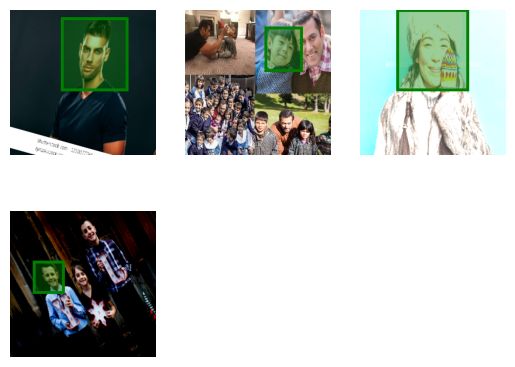

In [6]:
utils.visualize_img(batch, config['batch_size'])

In [ ]:
epochs = config['epochs']
logging = config['logging']
log_interval = config["log_wieghts_interval"]


if logging: 
    # read secrets for cometml logging
    with open('secrets.json') as secrets_file:
        secrets = json.load(secrets_file)

    # init experimenxt
    experiment = Experiment(
        api_key=secrets["api_key"],
        project_name=secrets["project_name"],
        workspace="reu-ds-club", 
    )

    hyper_params = {
        "model_name": config["model"],
        "use_colab": config['use_colab'], 
        "epochs": epochs,
        "batch_size": config['batch_size'], 
        "image_size": config['img_size'], 
    }

    experiment.log_parameters(hyper_params)

for epoch in range(epochs):
    epoch_loss = 0.0
    for sample in (pbar := tqdm(dataloader_for_detection)):

        img, box = sample[0].to(device), sample[1].to(device)
        img = img.to(torch.float32)

        box = box.to(torch.float32)
        optimizer.zero_grad()
        pred = detection_model(img)
        # loss = loss_fn(pred, box)

        loss = loss_fn(pred[0], pred[1], box)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}\tLoss: {epoch_loss / len(dataloader_for_detection)}")

    checkpoint_filename = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': detection_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, checkpoint_filename)

    if logging:
        experiment.log_metric("loss", epoch_loss, step=epoch)
    
    # logging model weights (accorging to log_interval + last epoch)
    if logging and (epoch % log_interval == 0 or epoch == epochs-1):
        torch.save(detection_model, 'model.pth')
        experiment.log_model(name = f"model-epoch-{epoch}", file_or_folder = 'model.pth', file_name = f"model-epoch-{epoch}")
        experiment.log_asset(file_data = 'model.pth', file_name = f"model-epoch-{epoch}")
        print("save model")


if logging:
    experiment.end()

In [7]:
#Face recognition setup
conv = ConvEmbedding().to(device)
triplet_model = Triplet(conv).to(device)
loss_for_recognition = TripletLoss(margin=5)
optimizer = torch.optim.Adam(triplet_model.parameters(), lr=1e-3)
epochs = 20

In [11]:
len(recognition_dataloader)

4083

In [10]:
for epoch in range(epochs):
    epoch_loss = 0

    for i, triplet in enumerate(recognition_dataloader):

        anc, pos, neg = triplet

        preds = triplet_model(anc.to(device), pos.to(device), neg.to(device))

        loss_val = loss_for_recognition(*preds)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        epoch_loss += loss_val.item()
        
        if i%5==0:
            print(f'{epoch} | [{i}/{len(recognition_dataloader)}] LOSS: {loss_val}')
        
    print(f'{epoch} | EPOCH LOSS: {loss_val}')

0 | [0/4083] LOSS: 4.9899678230285645
0 | [5/4083] LOSS: 4.828950881958008
0 | [10/4083] LOSS: 2.0965113639831543
0 | [15/4083] LOSS: 4.954373836517334
0 | [20/4083] LOSS: 4.998796463012695
0 | [25/4083] LOSS: 5.002302646636963
0 | [30/4083] LOSS: 4.9977312088012695
0 | [35/4083] LOSS: 4.992169380187988
0 | [40/4083] LOSS: 4.998960494995117
0 | [45/4083] LOSS: 4.997317790985107
0 | [50/4083] LOSS: 5.000369548797607
0 | [55/4083] LOSS: 5.000226020812988
0 | [60/4083] LOSS: 5.001129150390625
0 | [65/4083] LOSS: 4.996389865875244
0 | [70/4083] LOSS: 5.004185676574707
0 | [75/4083] LOSS: 5.024327278137207
0 | [80/4083] LOSS: 4.999454498291016
0 | [85/4083] LOSS: 4.999821186065674
0 | [90/4083] LOSS: 5.001814842224121
0 | [95/4083] LOSS: 4.934751033782959


KeyboardInterrupt: 